helpfull repo 
https://github.com/karolzak/conv3d-video-action-recognition


issues:
- not going throw the data set even once as I did specify the steps per epoch
  in  a very wrong way 
- normalization , seam not to work also the paper did not mention it 
- also indexing the pandas series made a big issue 
- also in this way the batch is not randomized enough 
- Iam using gap between the video segments to be 8 may be I need to try another
  thing !!!!


Things I learned 
 - always make sure about the settings that some pretrained weights/models get
   trained with , as if U did not specify the right preprocessing U can get 
   results that are worse than the model trained form scratch 

# the preprocessing that the dude did 
 is subtracting mean from all images 
and the mean is caulated from all images per channel 

# questions and Answers 
- get the number of frames in a video 

https://stackoverflow.com/questions/25359288/how-to-know-total-number-of-frame-in-a-file-with-cv2-in-python

# things to add to enhance the model 
- add randomness in the frame selection in trainning and testing 
- the way we do the vote processes 
- decrease the learnign rate 
- subtract the mean 
- train the model on the whole data set
- read the paper again 
- increase regularization 
- think for a while about it 
- read the middle portion not the juttered one



In [0]:
# imports
%tensorflow_version 1.x

from keras import Sequential 
from keras.layers import Conv3D
from keras.layers import Dense, Flatten
from keras.layers import MaxPooling3D, Dropout
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.layers import ZeroPadding3D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.regularizers import l2 

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os 
import pickle 
import math

In [0]:
# hyper parameters

LR = 0.003
Num_Epochs = 16
Batch_size = 30
Segment_length = 16
Gap = 16
Number_of_classes = 5
FC_drop_val = 0.5
FC_reg_val = 0
CNN_reg_val = 0
"""
this was a very big issue as 
the model didn't even go throw the data set for once 
"""

Total_training_batches = 164   
Total_validation_batches = 2
InputH = 112
InputW = 112
InputC = 3

Training_file_path = "/content/Training"

In [0]:
# download

# training data set 
!gdown --id  1fu93ErsAOzDf9kK2ws4I2ILcMYr2SZbF
# testing data set 
!gdown --id 1tfcRgZrMp8cVJeH-YY2YO0RJEe9dKMVy
# pretrained weights
!wget "https://privdatastorage.blob.core.windows.net/github/video-action-recognition/weights_C3D_sports1M_tf.h5"

In [0]:
#extract files 

!unrar x "/content/Training_set.rar"
!unrar x "/content/Testing_set.rar"

In [0]:
# utils 
def save_file(X , name):
    with open(name , 'wb') as f:
      pickle.dump(X , f)
    return 


def freeze(model):
  """
  freeze all expect the last layer 
  """
  for layer in model.layers[:-4]:
      layer.trainable = False
  return 


"""
#calculate the statistics for images 
#over all the data set 

- per channel mean over all the data set 
  for videos.

"""
def clac_number_of_frames(file_path):
    Number_of_frames = 0
    classes = os.listdir(file_path)
    for class_name in classes:
        class_path  = os.path.join(file_path, class_name)
        videos = os.listdir(class_path)
        for video_name in videos:
            video_path = os.path.join(class_path , video_name)
            video = cv2.VideoCapture(video_path)
            Number_of_frames +=  int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    return Number_of_frames

def stats(file_path):

  Number_of_frames = clac_number_of_frames(file_path)
  print("number of frames is : ",Number_of_frames)
  # I assume that all frames have same height and width
  Height = 240
  Width =  320

  BGR_means = [0 , 0 , 0]
  
  classes = os.listdir(file_path)
  cnt = 1
  for class_name in classes:
      class_path  = os.path.join(file_path, class_name)
      videos = os.listdir(class_path)
      for video_name in videos:
          video_path = os.path.join(class_path , video_name)
          
          #print(video_path)

          video = cv2.VideoCapture(video_path)
          while(True):
              ret , frame = video.read()
              if not ret:
                  break
              cnt +=1
              Red = 0
              Green = 0
              Blue = 0
              # BGR
              #print(frame.shape)
              Blue = np.sum(frame[: , :, 0])
              Blue /= Height 
              Blue /= Width 
              Blue /= Number_of_frames 

              Green = np.sum(frame[: , :, 1])
              Green /= Height 
              Green /= Width 
              Green /= Number_of_frames

              Red = np.sum(frame[: , :, 2])
              Red /= Height 
              Red /= Width 
              Red /= Number_of_frames

              # early reduction to avoid overflow
              BGR_means[0] += Blue
              BGR_means[1] += Green  
              BGR_means[2] += Red

          print("current stat are ", BGR_means)
          print("count is ", cnt)

  np.save('BGR_means.npy', BGR_means)
  print("done")
  return 


#stats('/content/Training')
#X = np.load("BGR_means.npy")
#print(X)

In [0]:
# preprocessing 
BGR_means = np.load("BGR_means.npy")
RGB_means = [ BGR_means[2] , BGR_means[1] , BGR_means[0] ]

def resize_img(img , tH=128, tW=171):
    img = cv2.resize(img ,  (tW, tH))  # order of parameters, right  !??
    H ,W , C = img.shape

    assert(H == tH and W ==tW and C==3)
    return img

def normalize_img_0_1(img):
  img = img /255.0
  img = img.astype(np.float32) # less memory
  return img


def jatter(img , tH=InputH, tW=InputW):
    H ,W , _  = img.shape
    limH = H - tH
    limW = W - tW

    startH = np.random.randint(low =0,high = limH+1)
    startW = np.random.randint(low =0 , high=limW+1)

    img = img[startH:startH+tH, startW:startW+tW, :]
    H , W , C = img.shape

    assert (H == tH and W == tW and C ==3)
    return img

def middle_portion(img):
    H , W , _ = img.shape
    sr = (H - InputH) // 2
    sc = (W - InputW) // 2

    new_img = img[sr:sr+InputH, sc:sc+InputW, :]
    H , W , C = new_img.shape
    assert( H == InputH and W == InputW and C == InputC)
    
    return new_img

def subtract_mean(img , means_file = 'BGR_means.npy'):
    new_img   = img - RGB_means
    return new_img

def preprocessing_pipeline(img, train=False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = normalize_img_0_1(img)
    """
    there is some sort of strange bug here 
    as all images get printed as 0 
    """
    img = resize_img(img)
    if train:
      img = jatter(img)
    else:
      img = middle_portion(img)

    #img = subtract_mean(img)
    
    img = img.astype(np.float32)
    return img


In [0]:
# agumentation 

def flip_img(img):
    """
    :param img:  rgb , float [0 , 1]
    """
    img = cv2.flip(img, 1) # horizontal
    return img


def augmentation_pipeline(img):
    """
    big note: apply it to all the frames togeather
    to represent new video segment
    """
    # fliped image
    images = []
    fliped_img = flip_img(img)
    images.append(fliped_img)
    return images

start data generator
here 0.0 250.0
(30, 16, 112, 112, 3) (30, 5)


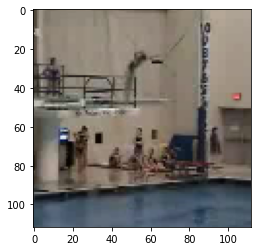

In [56]:
# Loading the data 

def generate_csv(Data_file_name, classes_file_path):
    names = pd.read_csv(classes_file_path)
    classes_names = list(names["Video"])
    assigned_labels = list(names['Label'])
    paths = []
    labels = []

    for index in range(0 , len(classes_names)):
        class_name = classes_names[index]
        class_path = os.path.join(Data_file_name, class_name)
        videos = os.listdir(class_path)

        for video_name in videos:
            video_path = os.path.join(class_path, video_name)
            paths.append(video_path)
            labels.append(assigned_labels[index])

    data = {"path":paths, "label":labels}
    df = pd.DataFrame (data, columns=['path', 'label'])
    df.to_csv('data.csv')
    return

def get_video_segments(video, sequence_length,  gap, precentage = 1):
    frames = []
    while True:
        not_empty, frame = video.read()
        if not not_empty: # = empty
            break
        frames.append(frame)

    segments = []
    for i in range(0 , len(frames), gap):
        end = i + sequence_length
        if end > len(frames):
            break
        tmp_segment = frames[i:end]
        segments.append(tmp_segment)
    return segments

def data_generator(paths, labels, train):
    print("start data generator")
    cnt = 0
    outer_index = 0
    batch_input = []
    batch_output = []

    paths = list(paths)
    labels = list(labels)

    #cnt = 0
    while True:

        video_path = paths[outer_index]
        #print(video_path)
        video_label = labels[outer_index]
        video_label = to_categorical(video_label , Number_of_classes)
        video = cv2.VideoCapture(video_path)
        
        #NUMBER_OF_SEG =  int(video.get(cv2.CAP_PROP_FRAME_COUNT)) // 16
        #cnt += NUMBER_OF_SEG
        #print(cnt)
        
        segments = get_video_segments(video, Segment_length, Gap, 1)
        for segment in segments:

            # augmentation
            if train:  
                new_segment = []
                for frame in segment:
                    images = augmentation_pipeline(frame)
                    new_segment.append(images[0])

            # preprocessing 
            for index in range(0 , len(segment)):
                if train:
                    new_segment[index] = preprocessing_pipeline(new_segment[index])
                segment[index] = preprocessing_pipeline(segment[index])

            batch_input.append(segment)
            batch_output.append(video_label)
            if train:
                batch_input.append(new_segment)
                batch_output.append(video_label)

            if len(batch_input) >= Batch_size:
                #cnt +=1
                batch_input = np.array(batch_input).reshape(-1 , Segment_length, InputH ,InputW, InputC)
                batch_output = np.array(batch_output).reshape(-1, Number_of_classes)
                yield batch_input, batch_output
                batch_input = []
                batch_output = []
        
        outer_index = (outer_index + 1)
        if outer_index == len(paths):
            #print("we have {} batch".format(cnt//Batch_size))
            #return 
            outer_index = 0; 
    
    print("end data generator")
    return

 
generate_csv(Training_file_path, 'names.csv')
Data = pd.read_csv("data.csv")
gen = data_generator(Data['path'], Data['label'], False)

# testing 
ins , out  = gen.__next__()
segment = ins[12]
frame = segment[15]
plt.imshow(frame/255)
print("here",np.min(frame) , np.max(frame))
print(ins.shape ,out.shape)

In [47]:


def C3D(frames_count, inputH, inputW, inputC, weight_path ="/content/weights_C3D_sports1M_tf.h5"):
  print("building C3D action recognition model")

  model = Sequential()
  
  # first conv group 
  model.add(Conv3D(64, (3,3,3), padding='same', activation='relu',
                   input_shape=(16, 112, 112, 3),  kernel_regularizer=l2(CNN_reg_val)))
  model.add(MaxPooling3D((1, 2,2)))

  # second conv group
  model.add(Conv3D(128, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val))) 
  model.add(MaxPooling3D((2,2,2)))

  # third conv group 
  model.add(Conv3D(256, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(Conv3D(256, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(MaxPooling3D((2,2,2)))

  # 4th conv group 
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(MaxPooling3D((2,2,2)))
  
  # 5th conv group
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu', kernel_regularizer=l2(CNN_reg_val)))
  model.add(ZeroPadding3D(padding=(0, 1, 1)))  # why we have this layer here !!!????
  model.add(MaxPooling3D((2,2,2)))
  
  # fully connected layers 
  model.add(Flatten())
  model.add(Dense(4096, activation='relu',  kernel_regularizer=l2(FC_reg_val)))
  model.add(Dropout(FC_drop_val))
  model.add(Dense(4096, activation='relu',  kernel_regularizer=l2(FC_reg_val)))
  model.add(Dropout(FC_drop_val))
  
  # output layer
  model.add(Dense(487, activation='softmax'))
  model.load_weights(weight_path)
  model.pop()
  model.add(Dense(5, activation='softmax',  kernel_regularizer=l2(FC_reg_val))) 
  # compile 
  opt = SGD(learning_rate = LR)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
  #print(model.summary())
  
  return model


"""def Edited_C3D():
  
  model = Sequential()
  model.add(Conv3D(64, (3,3,3), padding='same', activation='relu',
                   input_shape=(Segment_length, InputH, InputW, InputC),  kernel_regularizer=l2(CNN_reg_val), name='cnn1'))
  model.add(MaxPooling3D((1, 2,2)))

  # second conv group
  model.add(Conv3D(128, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val))) 
  model.add(MaxPooling3D((2,2,2)))

  # third conv group 
  model.add(Conv3D(256, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val), name='conv_3'))
  model.add(Conv3D(256, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(MaxPooling3D((2,2,2)))

  # 4th conv group 
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(MaxPooling3D((2,2,2)))
  
  # 5th conv group
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))
  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu', kernel_regularizer=l2(CNN_reg_val)))
  model.add(ZeroPadding3D(padding=(0, 1, 1)))  # why we have this layer here !!!????
  model.add(MaxPooling3D((2,2,2)))
  
  # fully connected layers 
  model.add(Flatten())
  model.add(Dense(1028, activation='relu',  kernel_regularizer=l2(FC_reg_val)))
  model.add(Dropout(FC_drop_val))
  model.add(Dense(1028, activation='relu',  kernel_regularizer=l2(FC_reg_val)))
  model.add(Dropout(FC_drop_val))
  
  # output layer
  model.add(Dense(5, activation='softmax',  kernel_regularizer=l2(FC_reg_val)))

  # compile 
  old_model =  C3D(16,112,112,3)
  for i in range(0 , 14 , 1):
      model.layers[i].set_weights(old_model.layers[i].get_weights())
  opt = SGD(learning_rate = LR)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
  return model
"""

"def Edited_C3D():\n  \n  model = Sequential()\n  model.add(Conv3D(64, (3,3,3), padding='same', activation='relu',\n                   input_shape=(Segment_length, InputH, InputW, InputC),  kernel_regularizer=l2(CNN_reg_val), name='cnn1'))\n  model.add(MaxPooling3D((1, 2,2)))\n\n  # second conv group\n  model.add(Conv3D(128, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val))) \n  model.add(MaxPooling3D((2,2,2)))\n\n  # third conv group \n  model.add(Conv3D(256, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val), name='conv_3'))\n  model.add(Conv3D(256, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))\n  model.add(MaxPooling3D((2,2,2)))\n\n  # 4th conv group \n  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))\n  model.add(Conv3D(512, (3,3,3), padding='same', activation='relu',  kernel_regularizer=l2(CNN_reg_val)))\n  model.add(MaxPooling3D((

In [0]:
# train 
print("start training")

model = C3D(16, 112, 112,3)
freeze(model)
opt = SGD(learning_rate = LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

# make sure that weights get assigned 
#print(model.layers[0].get_weights())



# load data 
Data = pd.read_csv('data.csv')
path = Data['path']
label = Data['label']

# split 
T_path , V_path , T_label , V_label = train_test_split(path, label, random_state=3, test_size = 0.01)

# get generators 
train_generator = data_generator(T_path, T_label, True)
valid_generator = data_generator(V_path, V_label, False)

# batches count 
T_steps_per_epoch = Total_training_batches
V_steps_per_epoch = Total_validation_batches

# set callbacks 
best_model = ModelCheckpoint('B_model.h5', monitor='accuracy' , save_best_only=True)

# fit the model
history = model.fit_generator(train_generator,
                    steps_per_epoch = T_steps_per_epoch,
                    validation_data = valid_generator,
                    validation_steps = V_steps_per_epoch,                     
                    verbose = 1,
                    epochs=Num_Epochs, 
                    callbacks = [best_model])

    


# save the model 
model.save_weights("final_weights.h5")
save_file(history.history, 'history.pickle')
print(" training ends ")

In [0]:
# predict

def predict_and_vote(segments , model):
    batch_input = np.array(segments).reshape(-1 , Segment_length , InputH, InputW , InputC)
    output = model.predict(batch_input)
    # do voting 
    votes = [0] * 5
    for i in range(0 , output.shape[0], 1):
        #print(output[i])
        index = np.argmax(output[i])
        votes[index]+=1
    #votes = np.sum(output , axis=0)
    #print(votes.shape)
    label = np.argmax(votes)
    return label

def predict(testing_file_path, model):
  """
  - load video 
  - get all of it's frames  using get video segment 
  - predict for all of them then do voting processes then record the label
  - repeat the above steps for the remaning videos 
  """
  VIDEOS = []
  LABELS = []
  names = os.listdir(testing_file_path)
  for video_name in names:
      video_path = os.path.join(testing_file_path, video_name)
      print(video_name)
      # read video
      video = cv2.VideoCapture(video_path)
      segments =  get_video_segments(video, 16, 1, 1)
    
      # preprocessing 
      for i in range(0, len(segments), 1):
          seg = segments[i]
          for index in range(0, len(seg), 1):
              frame = seg[index]
              frame = preprocessing_pipeline(frame, False)
              seg[index] = frame 
          segments[i] = seg

      # predict for each segment 
      label = predict_and_vote(segments , model)
      VIDEOS.append(video_name)
      LABELS.append(label)
  return VIDEOS , LABELS


def build_out_csv(videos , labels):
    data = {"Video":videos, "Label":labels}
    df = pd.DataFrame(data)
    df.to_csv("submit.csv")
    return 
model = load_model("/content/B_model.h5")
videos , labels = predict("/content/Testing_set", model)
build_out_csv(videos, labels)
print("done with prediction")

test_image (24).mpg
test_image (5).mpg
test_image (119).mpg
test_image (102).mpg
test_image (32).mpg
test_image (97).mpg
test_image (105).mpg
test_image (20).mpg
test_image (98).mpg
test_image (85).mpg
test_image (35).mpg
test_image (95).mpg
test_image (87).mpg
test_image (41).mpg
test_image (49).mpg
test_image (94).mpg
test_image (29).mpg
test_image (30).mpg
test_image (59).mpg
test_image (118).mpg
test_image (13).mpg
test_image (64).mpg
test_image (111).mpg
test_image (120).mpg
test_image (52).mpg
test_image (84).mpg
test_image (38).mpg
test_image (92).mpg
test_image (103).mpg
test_image (50).mpg
test_image (10).mpg
test_image (70).mpg
test_image (74).mpg
test_image (43).mpg
test_image (1).mpg
test_image (82).mpg
test_image (14).mpg
test_image (39).mpg
test_image (36).mpg
test_image (8).mpg
test_image (90).mpg
test_image (62).mpg
test_image (63).mpg
test_image (77).mpg
test_image (56).mpg
test_image (107).mpg
test_image (19).mpg
test_image (113).mpg
test_image (116).mpg
test_image (4